In [2]:
import torch
import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.nn.functional as F
from pennylane import qml

In [3]:
num_qubits_head = 7  # 7 qubit per il primo circuito
num_qubits_tail = 6  # 6 qubit per il secondo circuito
n_a_qubits = 1  # 1 qubit ancilla

device1 = qml.device("default.qubit", wires=num_qubits_head)
device2 = qml.device("default.qubit", wires=num_qubits_tail)

@qml.qnode(device1)
def quantum_circuit(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(num_qubits_tail), normalize=True)
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits_head))
    return qml.probs(wires=range(num_qubits_head))

@qml.qnode(device2)
def quantum_circuit1(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(num_qubits_tail), normalize=True)
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits_tail))
    return qml.probs(wires=range(num_qubits_tail))

class QuantumDenoiser(nn.Module):
    def __init__(self, n_layers=10):
        super().__init__()
        self.n_qubits = num_qubits_head
        self.n_qubits1 = num_qubits_tail
        self.n_a_qubits = n_a_qubits
        
        weight_shapes = {"weights": (n_layers, num_qubits_head, 3)}
        weight_shapes1 = {"weights": (n_layers, num_qubits_tail, 3)}
        
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.qlayer1 = qml.qnn.TorchLayer(quantum_circuit1, weight_shapes1)

    def forward(self, x):
        probs = self.qlayer(x)
        probsgiven0 = probs[:, : (2 ** (self.n_qubits - self.n_a_qubits))]
        probsgiven0 /= torch.sum(probs)
        return self.qlayer1(probsgiven0)

In [4]:
# Parametri
num_qubits = 6
batch_size = 4  # Numero di immagini da processare in batch
total_steps = 30
max_noise = 0.3

# Dispositivo quantistico
dev = qml.device("default.mixed", wires=num_qubits)

@qml.qnode(dev, interface="torch")
def mnist_to_quantum_state(image_vector, noise_param):
    qml.AmplitudeEmbedding(image_vector, wires=range(num_qubits), normalize=True)
    for i in range(num_qubits):
        qml.DepolarizingChannel(noise_param, wires=i)
    return qml.state()

def reconstruct_image(quantum_state):
    amplitudes = torch.sqrt(torch.real(torch.diag(quantum_state)))
    amplitudes = amplitudes / torch.norm(amplitudes)
    return amplitudes.reshape(8, 8)

def depolarize_images(batch, batch_size):
    depolarized_images = torch.empty(total_steps, batch_size, 8, 8)
    
    for step in range(total_steps):
        current_noise = max_noise * (step + 1) / total_steps
        
        for b in range(batch_size):
            quantum_state = mnist_to_quantum_state(batch[b], current_noise)
            depolarized_image = reconstruct_image(quantum_state)
            
            # Salva l'immagine depolarizzata nel tensore risultante
            depolarized_images[step, b] = depolarized_image
    
    return depolarized_images

In [5]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
import random

IMG_SIZE = 8  # Dimensione delle immagini (8x8)
BATCH_SIZE = 32
NUM_SAMPLES_PER_CLASS = 1600

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Ridimensiona le immagini a 8x8
    transforms.ToTensor()  # Converte le immagini in tensori
])

# Scarica il dataset MNIST con la trasformazione applicata
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Crea sottoinsiemi per le cifre 0 e 1
indices_zero = [i for i, (_, label) in enumerate(trainset) if label == 0]
indices_one = [i for i, (_, label) in enumerate(trainset) if label == 1]

# Seleziona casualmente 50 indici per ciascuna classe
random.shuffle(indices_zero)
random.shuffle(indices_one)
selected_indices_zero = indices_zero[:NUM_SAMPLES_PER_CLASS]
selected_indices_one = indices_one[:NUM_SAMPLES_PER_CLASS]

# Crea i sottoinsiemi con gli indici selezionati
zero_subset = Subset(trainset, selected_indices_zero)
one_subset = Subset(trainset, selected_indices_one)

# Combina i due sottoinsiemi
combined_subset = ConcatDataset([zero_subset, one_subset])

# Crea il DataLoader
trainloader = DataLoader(combined_subset, batch_size=BATCH_SIZE, shuffle=True)

# Verifica
total_samples = len(combined_subset)
print(f"Totale campioni nel dataset: {total_samples}")

# Estrai un batch di dati
images, labels = next(iter(trainloader))
images_flat = images.view(images.size(0), -1)

print(f"Forma delle immagini appiattite: {images_flat.shape}")
print(f"Etichette nel batch: {labels}")

Totale campioni nel dataset: 3200
Forma delle immagini appiattite: torch.Size([32, 64])
Etichette nel batch: tensor([1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1])


Digit 1, Step: 1, Noise: 0.010, Purity: 0.893123
Digit 1, Step: 2, Noise: 0.020, Purity: 0.797627
Digit 1, Step: 3, Noise: 0.030, Purity: 0.712345
Digit 1, Step: 4, Noise: 0.040, Purity: 0.636227
Digit 1, Step: 5, Noise: 0.050, Purity: 0.568320
Digit 1, Step: 6, Noise: 0.060, Purity: 0.507769
Digit 1, Step: 7, Noise: 0.070, Purity: 0.453801
Digit 1, Step: 8, Noise: 0.080, Purity: 0.405720
Digit 1, Step: 9, Noise: 0.090, Purity: 0.362900
Digit 1, Step: 10, Noise: 0.100, Purity: 0.324779
Digit 1, Step: 11, Noise: 0.110, Purity: 0.290852
Digit 1, Step: 12, Noise: 0.120, Purity: 0.260666
Digit 1, Step: 13, Noise: 0.130, Purity: 0.233814
Digit 1, Step: 14, Noise: 0.140, Purity: 0.209933
Digit 1, Step: 15, Noise: 0.150, Purity: 0.188697
Digit 1, Step: 16, Noise: 0.160, Purity: 0.169814
Digit 1, Step: 17, Noise: 0.170, Purity: 0.153025
Digit 1, Step: 18, Noise: 0.180, Purity: 0.138097
Digit 1, Step: 19, Noise: 0.190, Purity: 0.124823
Digit 1, Step: 20, Noise: 0.200, Purity: 0.113019
Digit 1, 

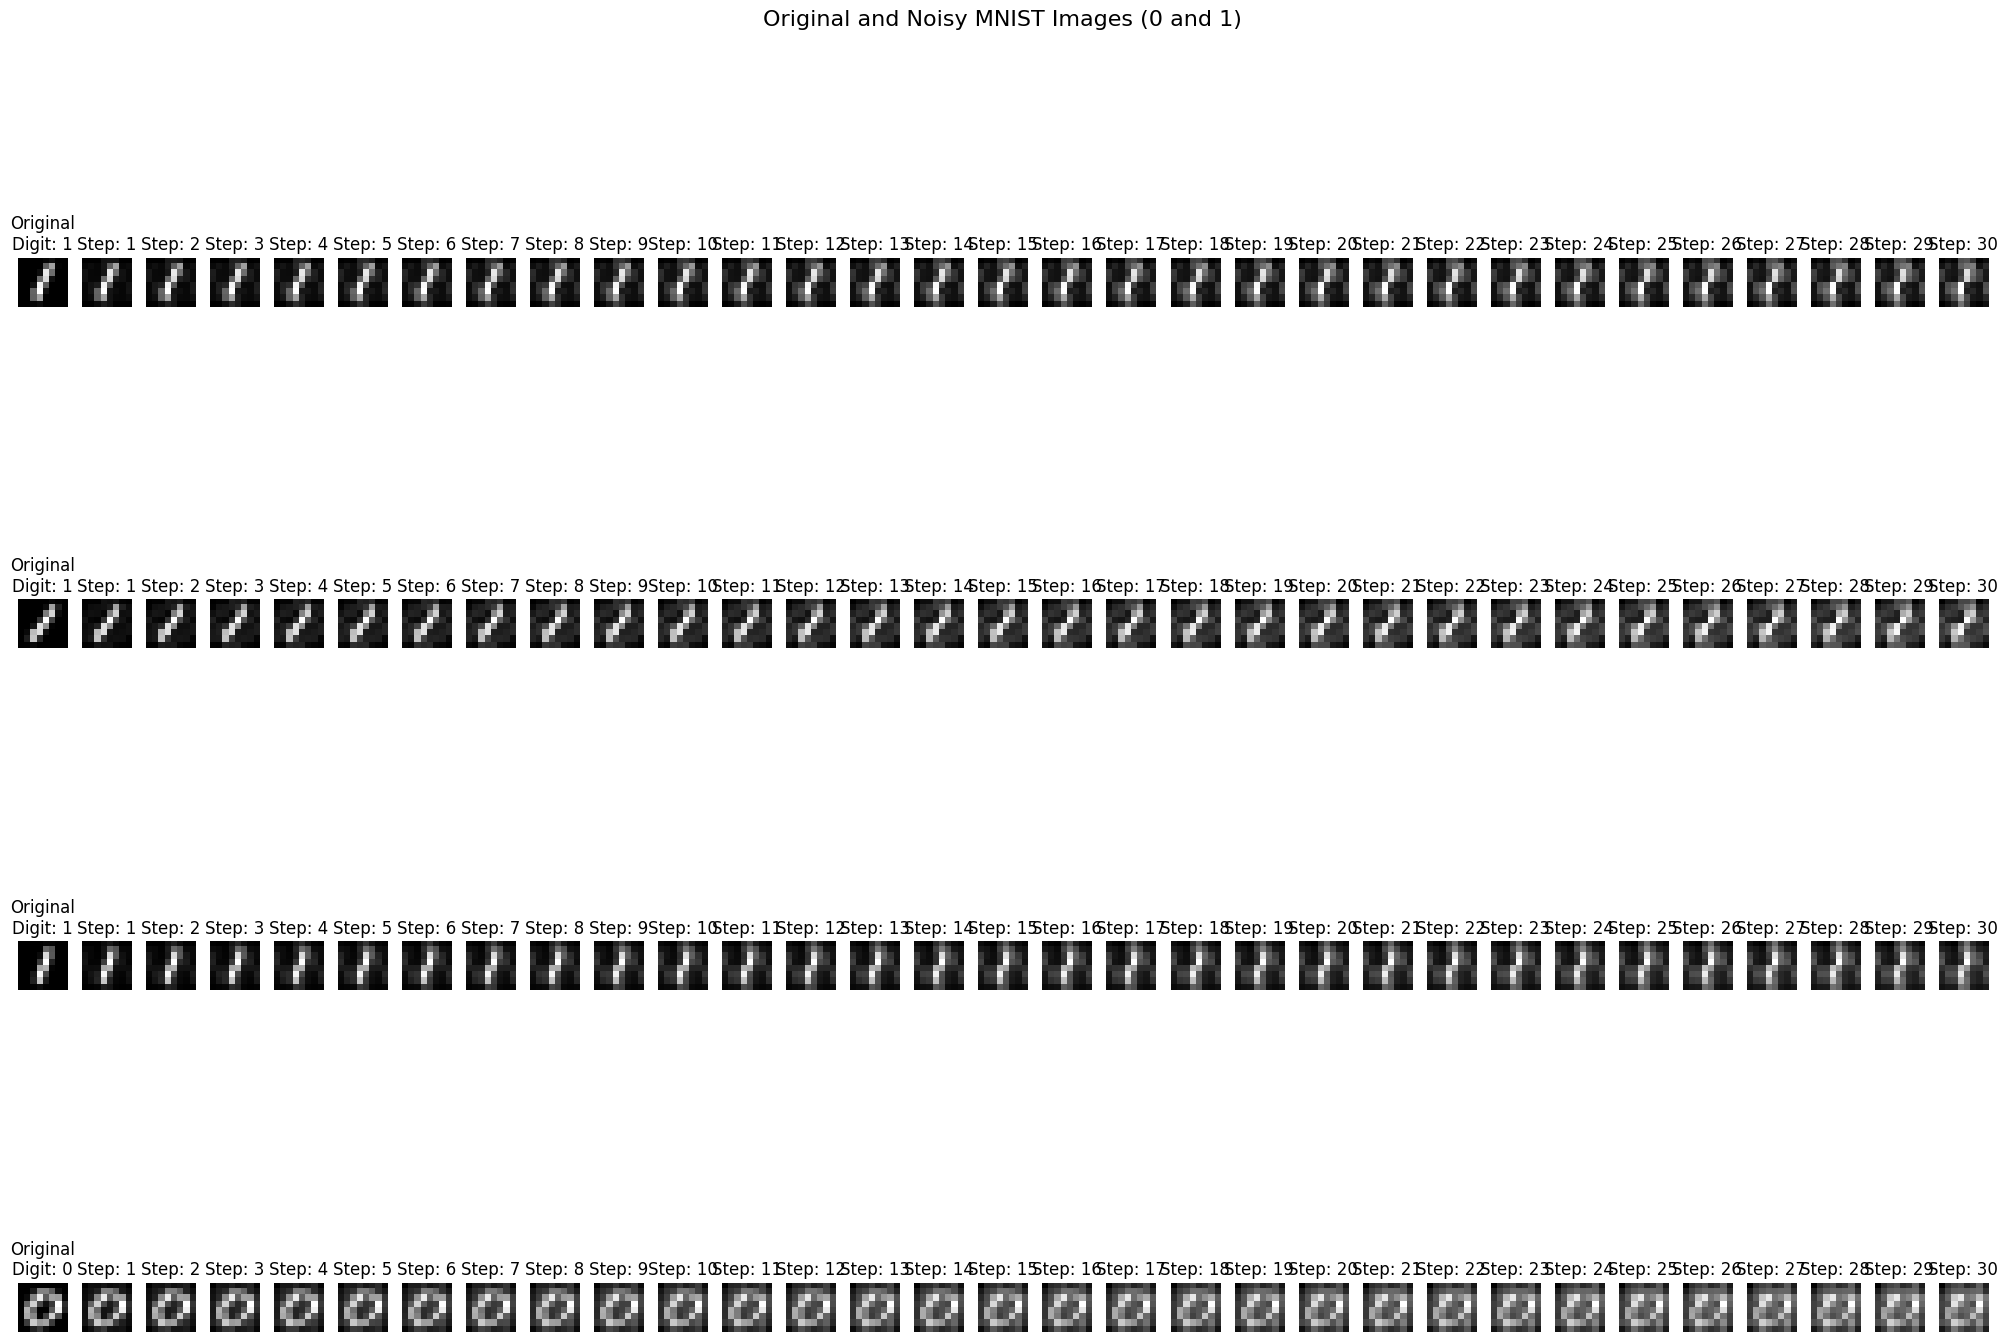

In [33]:
fig, axes = plt.subplots(4, total_steps + 1, figsize=(20, 16))  # 4 righe per una migliore visualizzazione
fig.suptitle("Original and Noisy MNIST Images (0 and 1)", fontsize=16)

for b in range(min(BATCH_SIZE, 4)):  # Visualizza solo le prime 4 immagini per chiarezza
    # Immagine originale
    axes[b, 0].imshow(images[b].squeeze(), cmap='gray')
    axes[b, 0].set_title(f"Original\nDigit: {labels[b].item()}")
    axes[b, 0].axis('off')

    # Applica il rumore gradualmente e visualizza i risultati
    for step in range(total_steps):
        current_noise = max_noise * (step + 1) / total_steps
        quantum_state = mnist_to_quantum_state(images_flat[b], current_noise)
        depolarized_image = reconstruct_image(quantum_state)

        axes[b, step + 1].imshow(depolarized_image.detach().numpy(), cmap='gray')
        axes[b, step + 1].set_title(f"Step: {step+1}")
        axes[b, step + 1].axis('off')

        purity = torch.real(torch.trace(torch.matmul(quantum_state, quantum_state)))
        print(f"Digit {labels[b].item()}, Step: {step+1}, Noise: {current_noise:.3f}, Purity: {purity:.6f}")

plt.tight_layout()
plt.show()

In [6]:
model = QuantumDenoiser(n_layers=25)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
num_epochs = 5

In [38]:
def backward_process(epoch, model):
    losses = []
    
    # Iteriamo prima sui batch
    for step, batch in enumerate(tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} - Batches', unit='batch')):
        batch_size = batch[0].shape[0]
        data = batch[0].reshape(batch_size, 8*8)
        data = depolarize_images(data, batch_size)
        depolarized_images = data.reshape(total_steps, batch_size, 8*8)
        xt = depolarized_images[total_steps-1]
        # Per ogni batch, iteriamo sui timestep in ordine inverso
        for t in tqdm(range(total_steps - 1, 0, -1), desc=f'Batch {step+1} - Timesteps', leave=False, unit='timestep'):
            optimizer.zero_grad()
            x_target = depolarized_images[t-1]
            xt_prev = model(xt.detach())
            loss = loss_fn(x_target, xt_prev)
            loss.backward()
            optimizer.step()
            xt = xt_prev
            losses.append(loss.item())
            
    return sum(losses) / len(losses)
    

In [39]:
for epoch in range(num_epochs):
    loss = backward_process(epoch, model)
    print(f"Epoch {epoch+1}, Average Loss: {loss:.6f}")

Epoch 1/5 - Batches: 100%|██████████| 100/100 [37:55<00:00, 22.76s/batch] 


Epoch 1, Average Loss: 0.010971


Epoch 2/5 - Batches: 100%|██████████| 100/100 [30:41<00:00, 18.41s/batch]


Epoch 2, Average Loss: 0.010942


Epoch 3/5 - Batches: 100%|██████████| 100/100 [30:42<00:00, 18.43s/batch]


Epoch 3, Average Loss: 0.010954


Epoch 4/5 - Batches: 100%|██████████| 100/100 [30:43<00:00, 18.43s/batch]


Epoch 4, Average Loss: 0.010924


Epoch 5/5 - Batches: 100%|██████████| 100/100 [30:49<00:00, 18.49s/batch]

Epoch 5, Average Loss: 0.010949


C:\Users\pevel\AppData\Local\Temp\ipykernel_12860\3081894221.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_image = torch.tensor(depolarized_images[step].flatten())


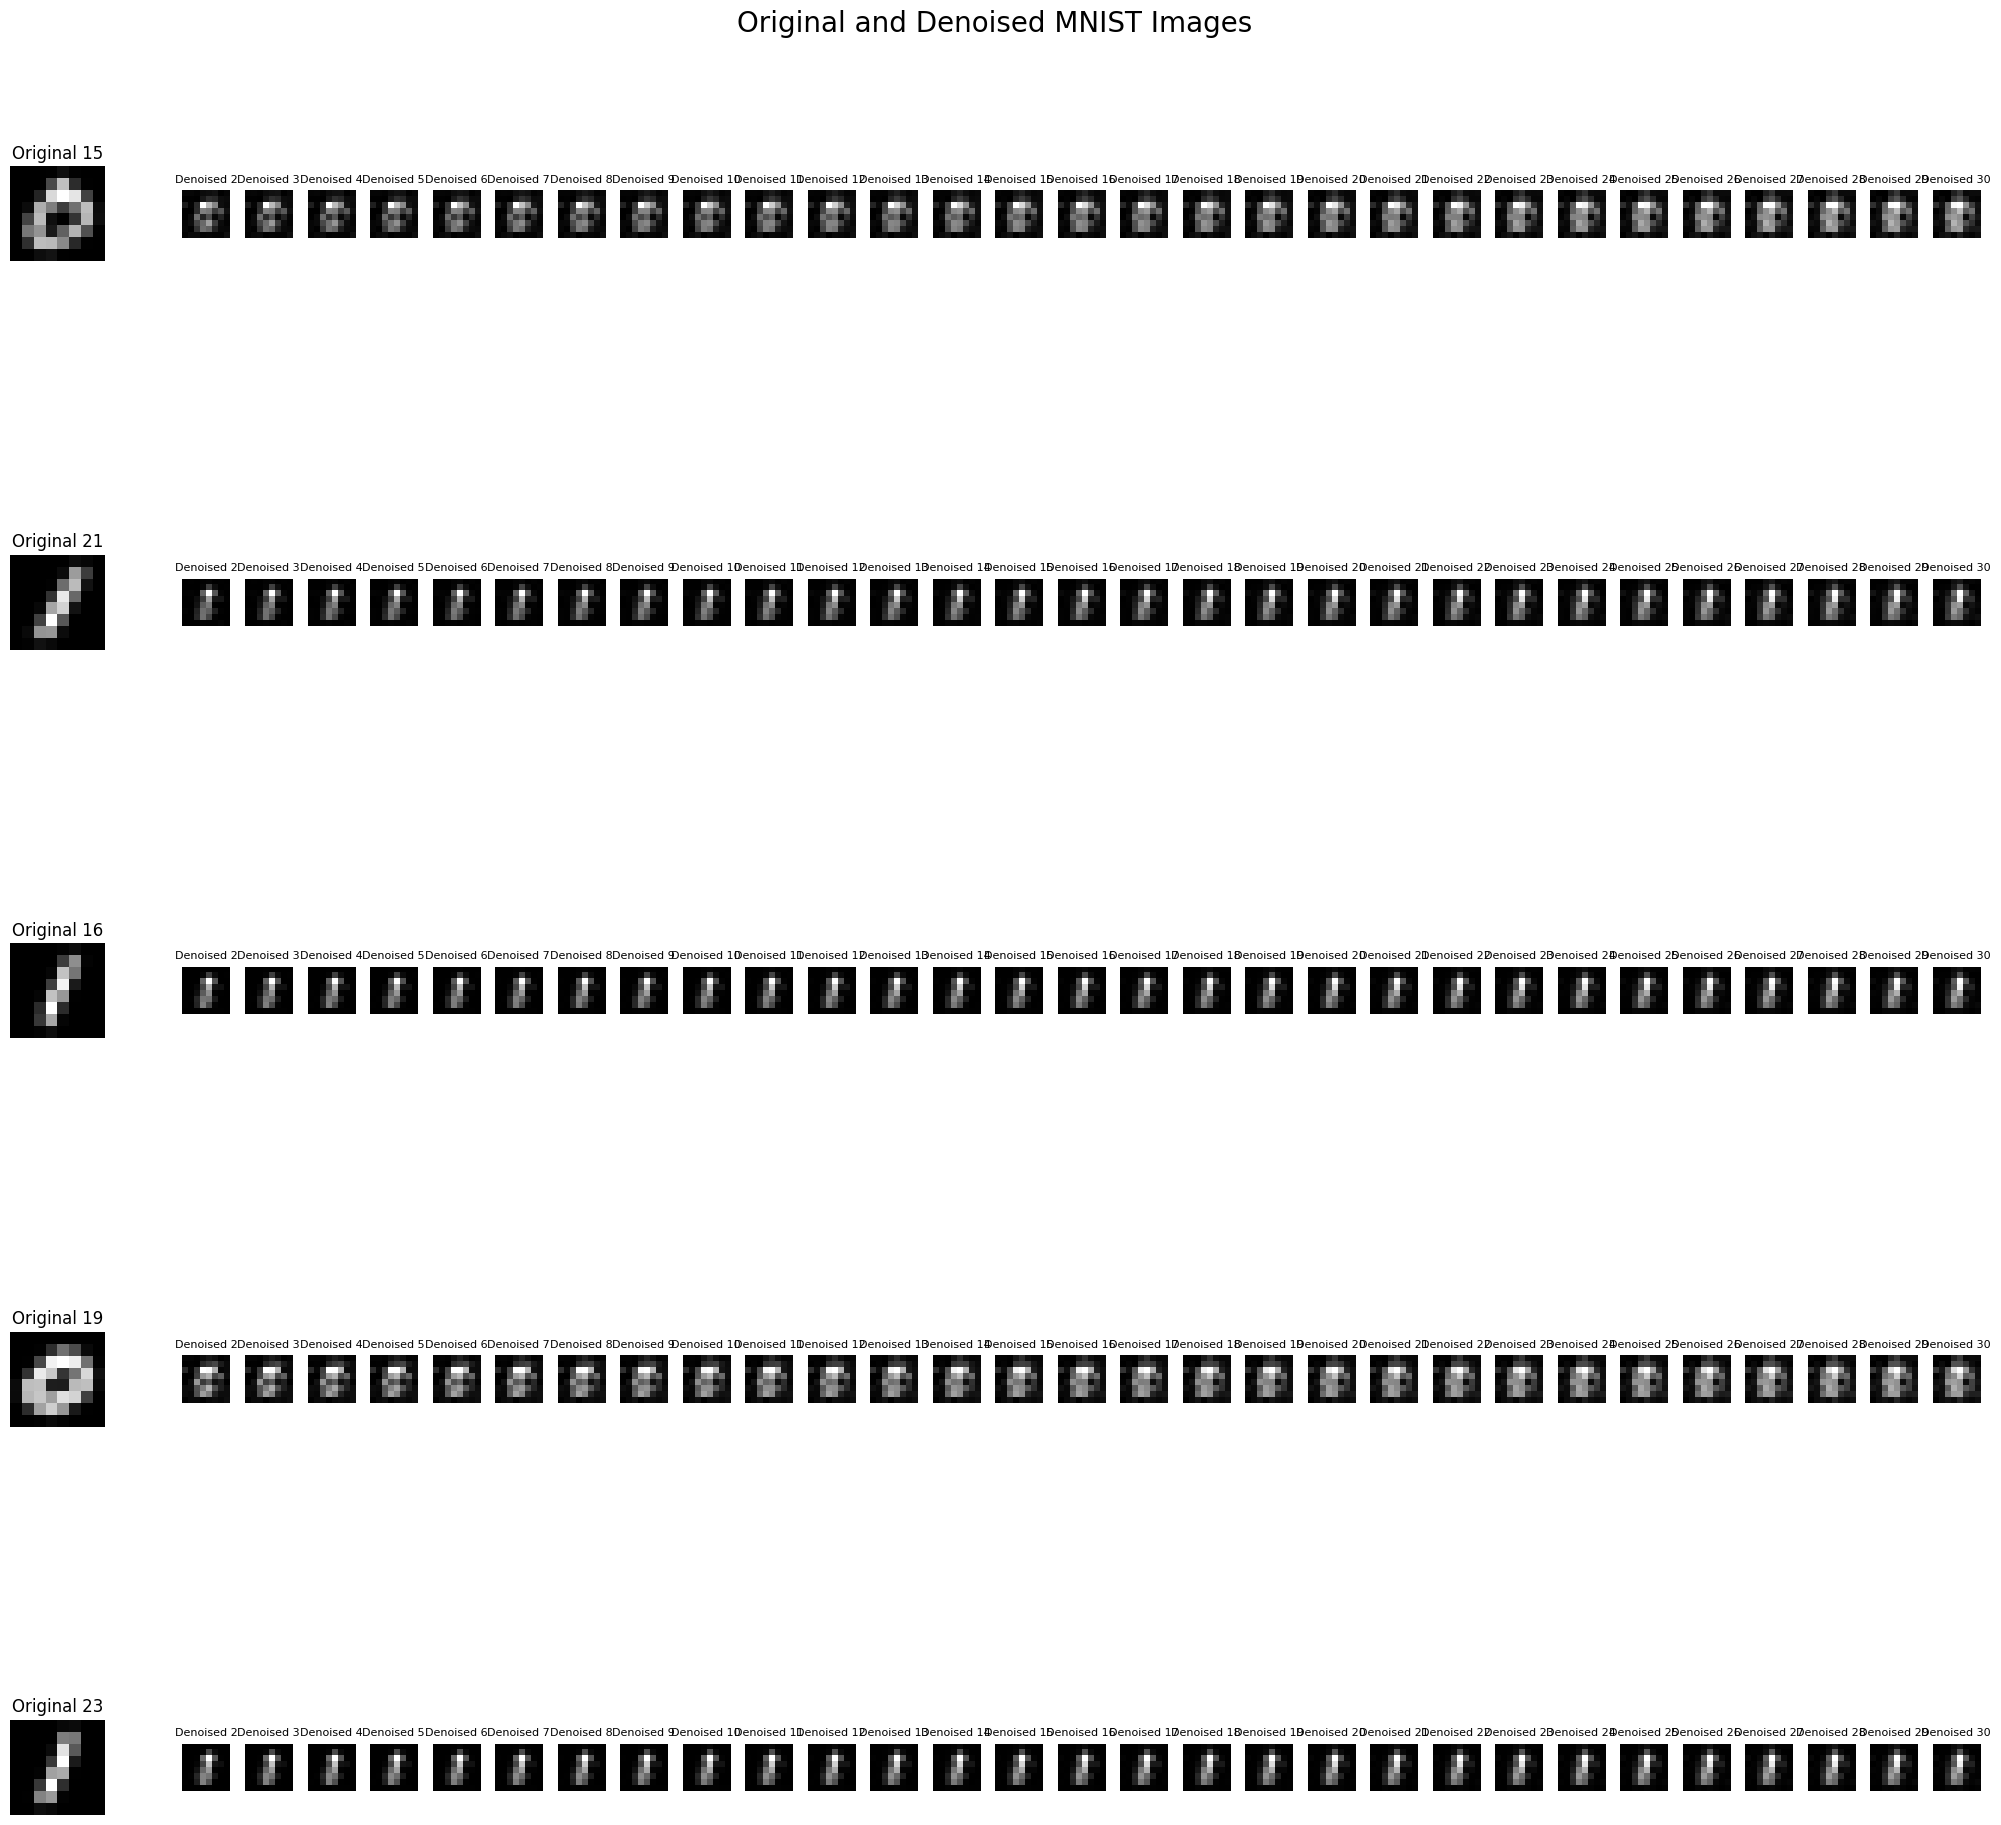

In [9]:
def visualize_denoising(model, num_examples=5):
    model.eval()  # Imposta il modello in modalità di valutazione
    
    # Ottieni un batch di dati per la visualizzazione
    batch = next(iter(trainloader))
    
    # Assicuriamoci di avere abbastanza immagini
    num_examples = min(num_examples, batch[0].shape[0])
    
    # Selezioniamo casualmente gli indici delle immagini da visualizzare
    example_indices = np.random.choice(batch[0].shape[0], num_examples, replace=False)
    
    # Creiamo il layout della figura
    fig = plt.figure(figsize=(20, 4*num_examples))
    gs = fig.add_gridspec(num_examples, total_steps + 1, width_ratios=[2] + [1]*total_steps)
    
    for i, idx in enumerate(example_indices):
        # Immagine originale
        ax_original = fig.add_subplot(gs[i, 0])
        ax_original.imshow(batch[0][idx].squeeze(), cmap='gray')
        ax_original.set_title(f"Original {idx}", fontsize=12)
        ax_original.axis('off')
        
        # Genera le immagini depolarizzate
        data = batch[0][idx].reshape(1, 8*8)
        depolarized_images = depolarize_images(data, 1).reshape(total_steps, 8, 8)
        
        # Immagini denoised
        for step in range(total_steps - 1, 0, -1):
            ax_denoised = fig.add_subplot(gs[i, step + 1])
            with torch.no_grad():
                noisy_image = torch.tensor(depolarized_images[step].flatten())
                noisy_image = noisy_image.unsqueeze(0)
                denoised_image = model(noisy_image).reshape(8, 8)
            ax_denoised.imshow(denoised_image.numpy(), cmap='gray')
            ax_denoised.set_title(f"Denoised {step+1}", fontsize=8)
            ax_denoised.axis('off')
    
    plt.suptitle("Original and Denoised MNIST Images", fontsize=20)
    plt.tight_layout()
    plt.show()

visualize_denoising(model, 5)

C:\Users\pevel\AppData\Local\Temp\ipykernel_12860\4158069193.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_image = torch.tensor(depolarized_images[-1].flatten())  # Ultimo step


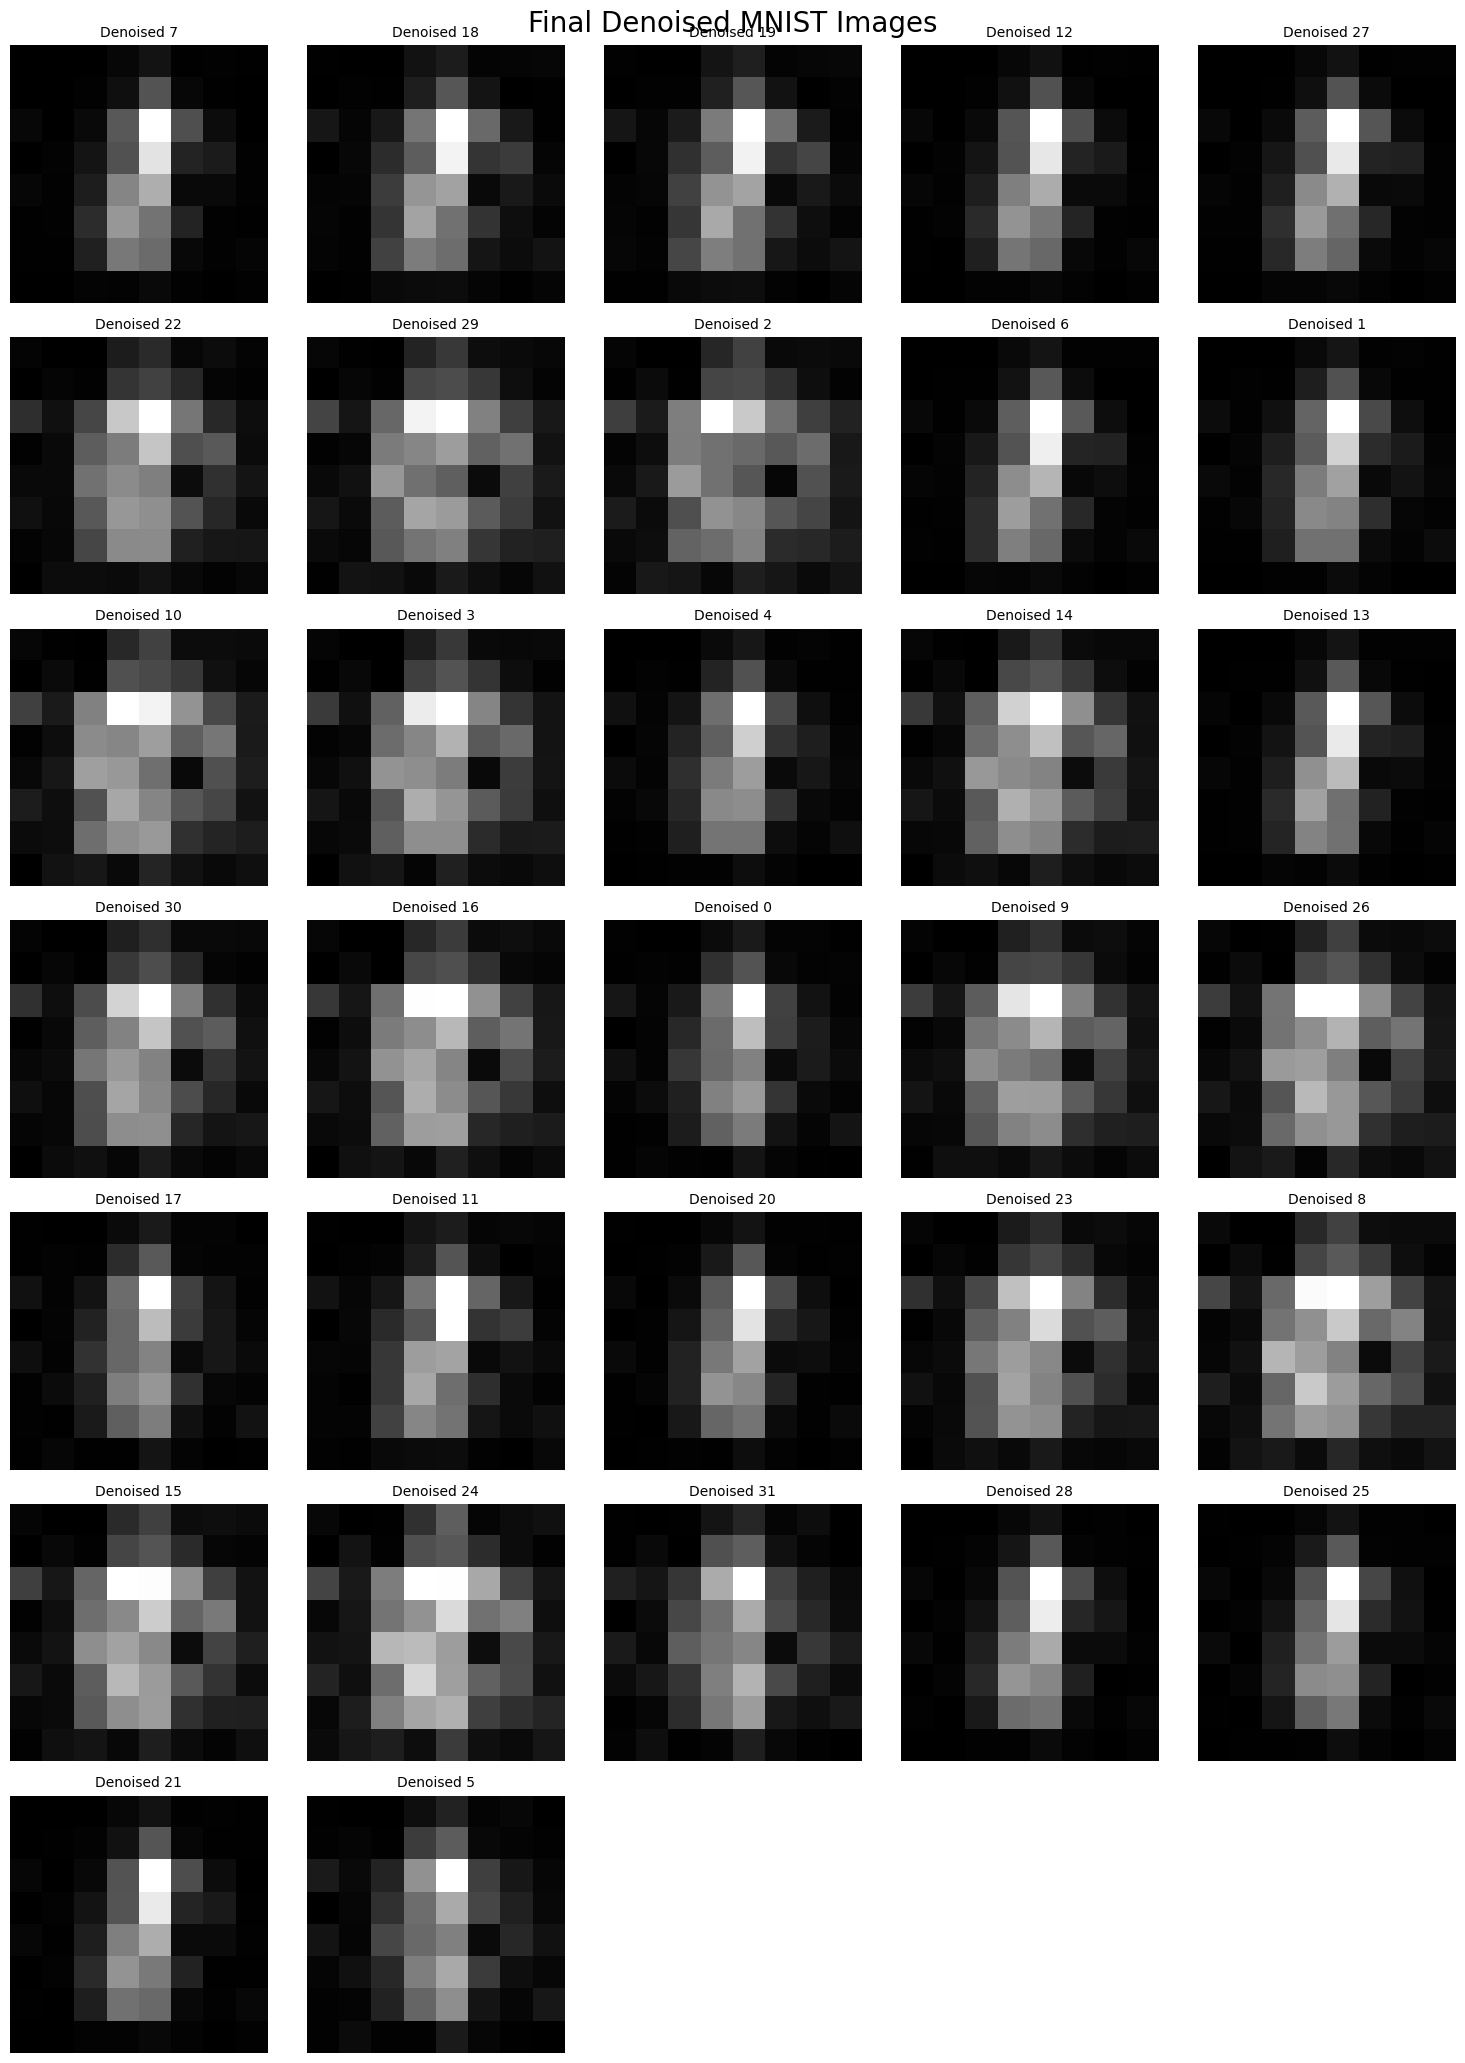

In [11]:
def visualize_final_denoised_images(model, num_examples=5):
    model.eval()  # Imposta il modello in modalità di valutazione
    
    # Ottieni un batch di dati per la visualizzazione
    batch = next(iter(trainloader))
    
    # Assicuriamoci di avere abbastanza immagini
    num_examples = min(num_examples, batch[0].shape[0])
    
    # Selezioniamo casualmente gli indici delle immagini da visualizzare
    example_indices = np.random.choice(batch[0].shape[0], num_examples, replace=False)
    
    # Creiamo il layout della figura in una matrice rettangolare
    cols = 5  # Numero di colonne nella matrice
    rows = (num_examples // cols) + int(num_examples % cols > 0)  # Numero di righe in base al numero di esempi
    
    fig, axs = plt.subplots(rows, cols, figsize=(15, 3*rows))  # Matrice di subplot
    axs = axs.flatten()  # Flattiamo la matrice di assi per accedere più facilmente agli assi
    
    for i, idx in enumerate(example_indices):
        # Genera l'immagine depolarizzata e denoised
        data = batch[0][idx].reshape(1, 8*8)
        depolarized_images = depolarize_images(data, 1).reshape(total_steps, 8, 8)
        
        # Immagine denoised all'ultimo timestep
        with torch.no_grad():
            noisy_image = torch.tensor(depolarized_images[-1].flatten())  # Ultimo step
            noisy_image = noisy_image.unsqueeze(0)
            denoised_image = model(noisy_image).reshape(8, 8)
        
        # Mostra l'immagine denoised
        axs[i].imshow(denoised_image.numpy(), cmap='gray')
        axs[i].set_title(f"Denoised {idx}", fontsize=10)
        axs[i].axis('off')  # Nascondi gli assi
    
    # Rimuoviamo eventuali assi vuoti (se il numero di esempi non è divisibile per il numero di colonne)
    for i in range(num_examples, len(axs)):
        fig.delaxes(axs[i])
    
    plt.suptitle("Final Denoised MNIST Images", fontsize=20)
    plt.tight_layout()
    plt.show()

visualize_final_denoised_images(model, 50)

In [43]:
def calculate_fidelity(state1, state2):
    # Assicuriamoci che gli stati siano 2D
    if state1.dim() == 1:
        state1 = state1.unsqueeze(0)
    if state2.dim() == 1:
        state2 = state2.unsqueeze(0)
    
    print(state1.shape)
    # Normalizza gli stati
    state1 = state1 / torch.norm(state1, dim=1, keepdim=True)
    state2 = state2 / torch.norm(state2, dim=1, keepdim=True)
    
    # Calcola il prodotto interno per ogni coppia di stati nel batch
    overlap = torch.sum(state1 * state2.conj(), dim=1)
    fidelity = torch.abs(overlap)**2
    
    return fidelity

def calculate_batch_fidelity(model, trainloader, depolarize_images, total_steps):
    model.eval()  # Imposta il modello in modalità di valutazione
    fidelities = []
    
    with torch.no_grad():
        for batch in trainloader:
            batch_size = batch[0].shape[0]
            original_images = batch[0].reshape(batch_size, 8*8)
            
            # Depolarizza le immagini
            depolarized_images = depolarize_images(original_images, batch_size)
            
            # Prendi l'ultimo stato depolarizzato (il più rumoroso)
            noisy_images = depolarized_images[total_steps-1]
            # Applica il denoising
            for step in range(total_steps-1, 0, -1):
                denoised_images = model(noisy_images.reshape(-1, 64))
            
            # Calcola la fidelity
            batch_fidelity = calculate_fidelity(original_images, denoised_images)
            fidelities.extend(batch_fidelity.tolist())
            break
    
    average_fidelity = sum(fidelities) / len(fidelities)
    return average_fidelity

In [44]:
avg_fidelity = calculate_batch_fidelity(model, trainloader, depolarize_images, total_steps)
print(f"Average Fidelity: {avg_fidelity:.4f}")

torch.Size([32, 64])
Average Fidelity: 0.6813


In [12]:
'''
torch.save(model.state_dict(), 'quantum_quantum_weights.pth')

print("Modello salvato correttamente in quantum_quantum_weights.pth")
'''

Modello salvato correttamente in quantum_quantum_weights.pth


In [8]:
# Inizializza il modello
model = QuantumDenoiser(n_layers=25)

# Carica i pesi salvati dal file .pth
model.load_state_dict(torch.load('quantum_quantum_weights.pth'))

print("Pesi del modello caricati correttamente.")

Pesi del modello caricati correttamente.


In [12]:
class ClassicalDenoiser(nn.Module):
    def __init__(self, input_size=64, hidden_size=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x):
        return self.model(x)

# Inizializzazione del modello e dell'ottimizzatore
model = ClassicalDenoiser()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()


for epoch in range(num_epochs):
    loss = backward_process(epoch, model)
    print(f"Epoch {epoch+1}, Average Loss: {loss:.6f}")

Epoch 1/5 - Batches:   8%|▊         | 32/396 [02:41<30:40,  5.06s/batch]


KeyboardInterrupt: 

In [76]:
avg_fidelity = calculate_batch_fidelity(model, trainloader, depolarize_images, total_steps)
print(f"Average Fidelity: {avg_fidelity:.4f}")

torch.Size([32, 8, 8])
Average Fidelity: 0.5133


C:\Users\pevel\AppData\Local\Temp\ipykernel_5004\3081894221.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_image = torch.tensor(depolarized_images[step].flatten())


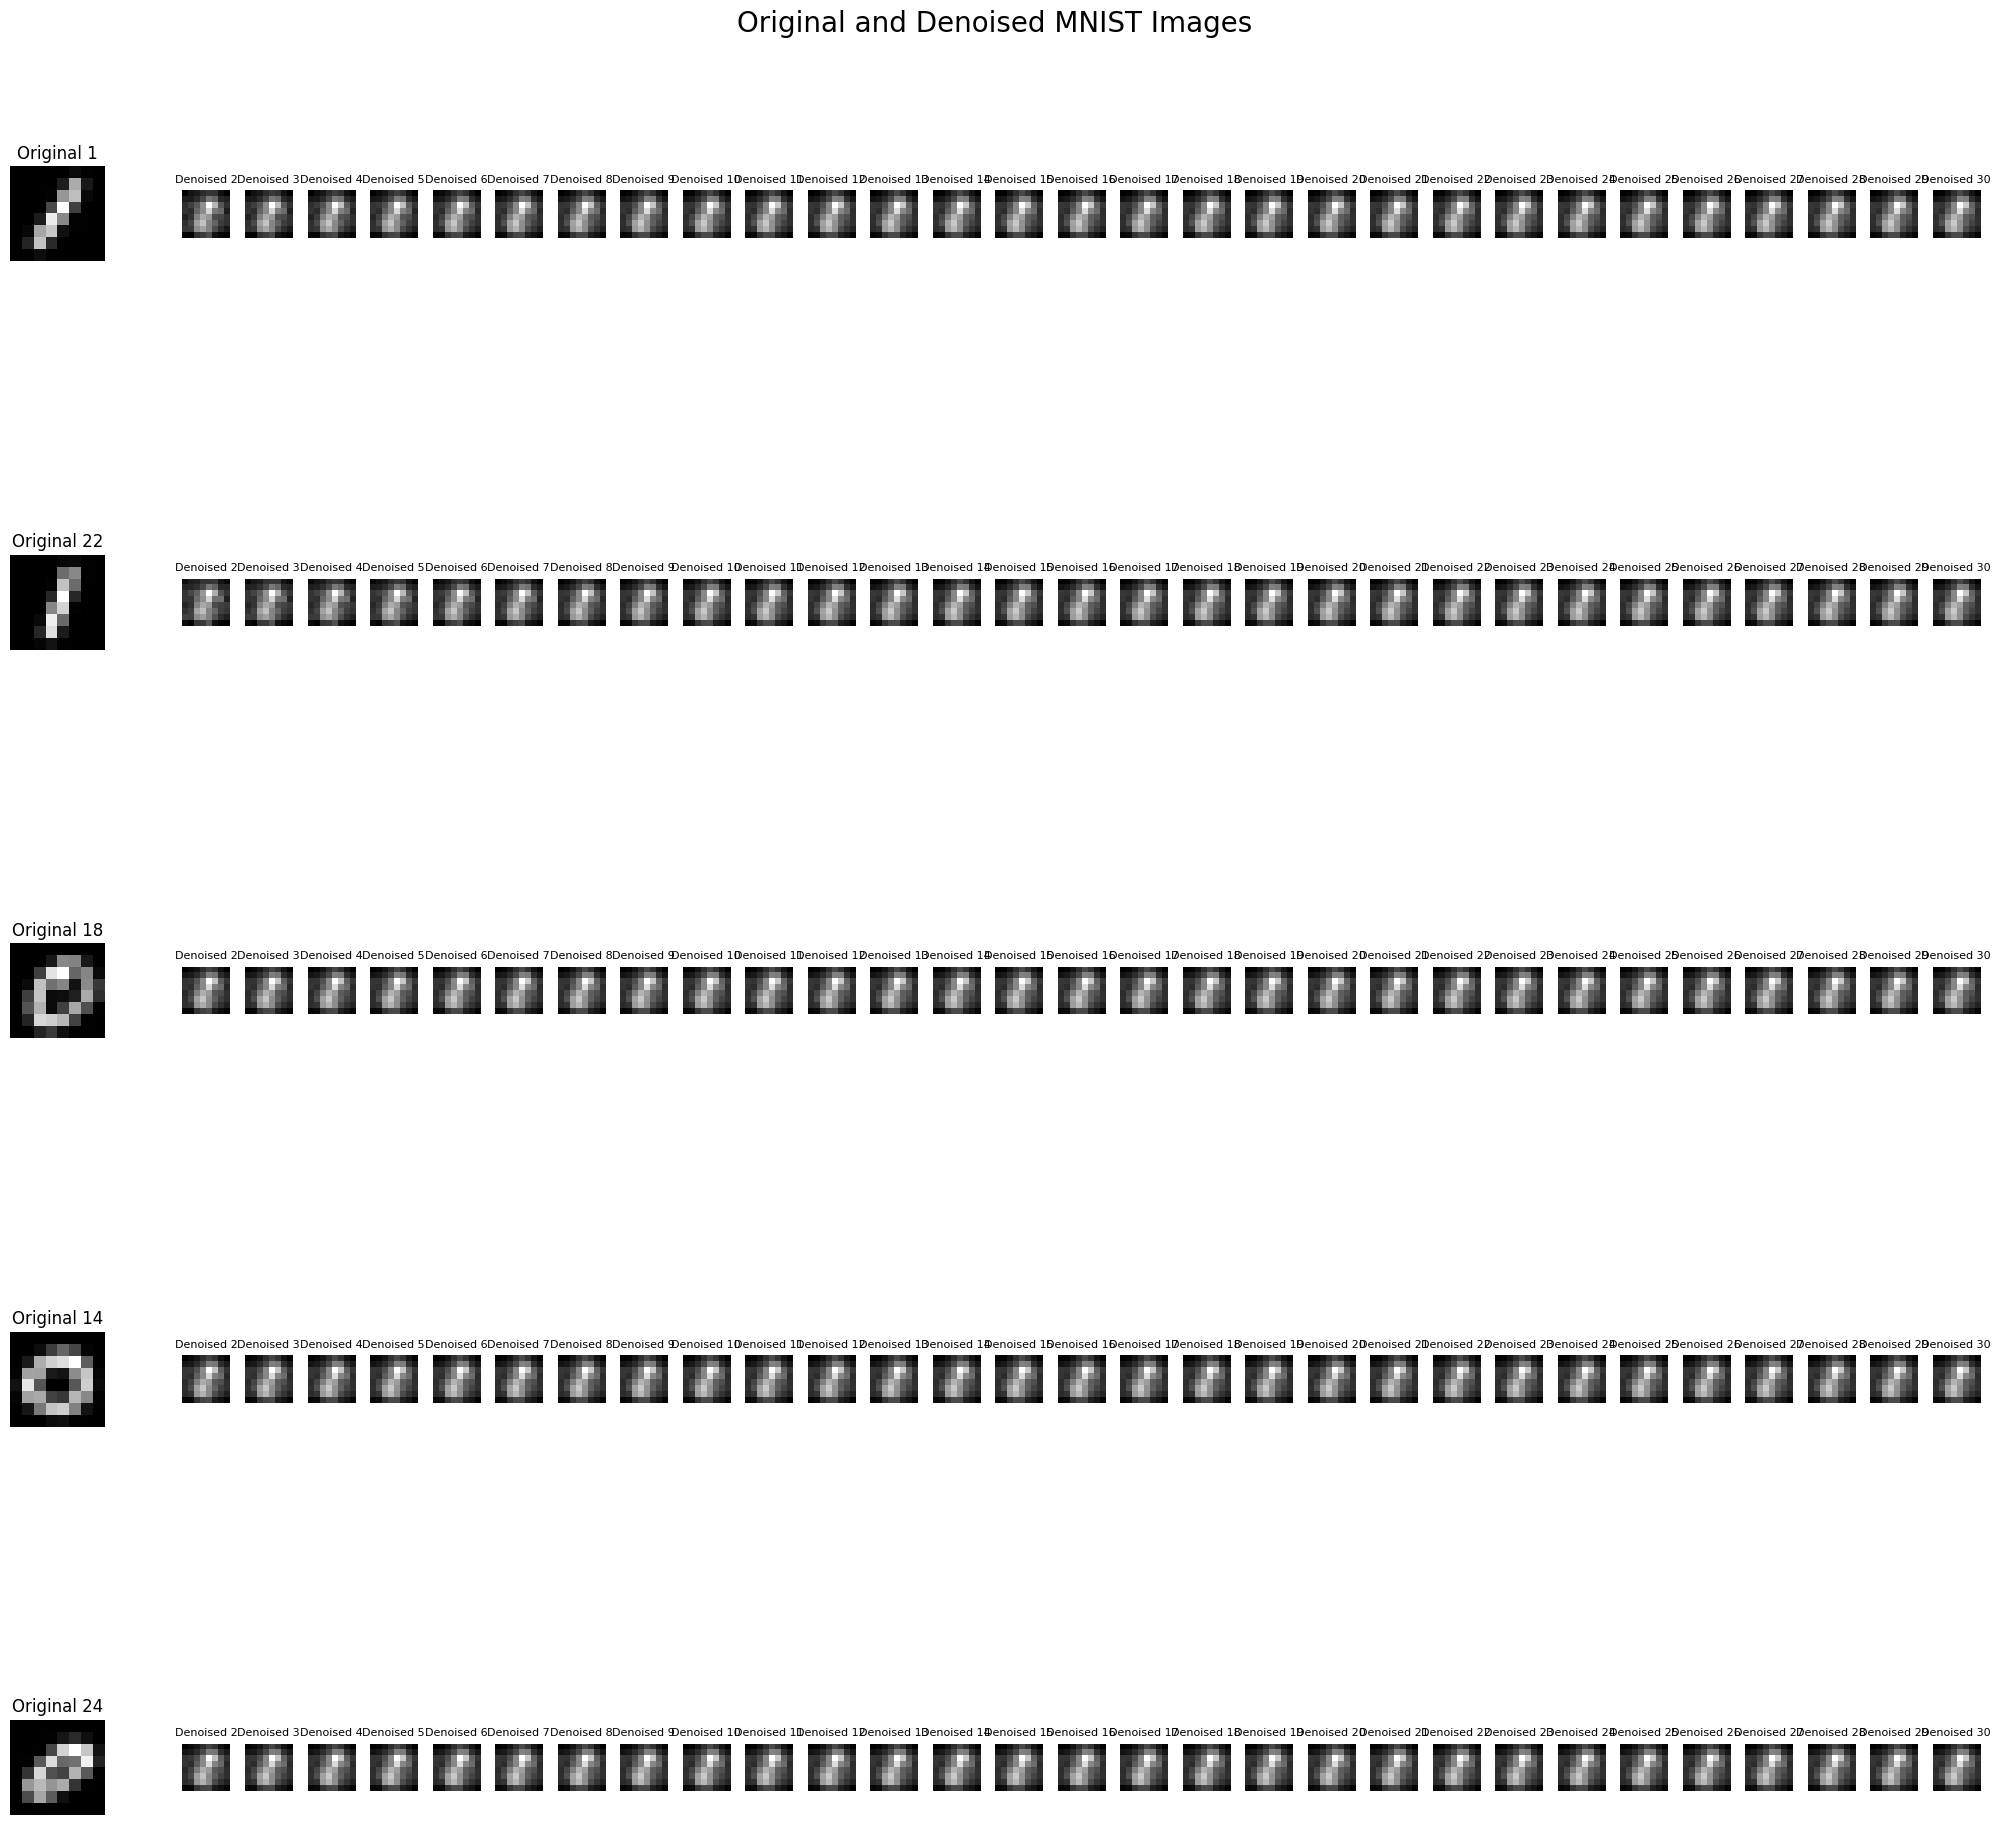

In [77]:
visualize_denoising(model, 5)